build a basic chatbot (graph api functionality)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

/Users/lakshmianand/Desktop/CHATBOT-AI-AGENT/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class State(TypedDict):
    messages :Annotated[list,add_messages]
graph_builder = StateGraph(State)

In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
graph_builder

In [5]:
from langchain_groq import ChatGroq 
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-70b-8192")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10d1f5550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10d219c10>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = init_chat_model("groq:llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10cebe760>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10d47ba00>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
##node functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


In [9]:
graphbuilder=StateGraph(State)
##adding the node to the graph
graphbuilder.add_node(
    "llmchatbot",
    chatbot)
##adding edges to the graph
graphbuilder.add_edge(START, "llmchatbot")
graphbuilder.add_edge("llmchatbot", END)

##compiling the graph
graph = graphbuilder.compile()

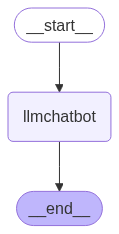

In [10]:
from IPython.display import Image, display
try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception :
    pass 

In [11]:
response = graph.invoke({"messages": ["Hello, how are you?"]})

In [12]:
response["messages"][-1].content

"I'm just a language model, I don't have emotions or feelings like humans do, so I don't have good or bad days. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?"

In [13]:
for event in graph.stream({"messages": ["Hello, how are you?"]}):
    for value in event.values():
        print(value["messages"][-1].content, end="", flush=True)

I'm just a language model, I don't have feelings or emotions like humans do, so I don't have good or bad days. I'm always "on" and ready to help with any questions or tasks you may have! How can I assist you today?

chatbot with tool:

In [14]:
from langchain_tavily import TavilySearch
tool = TavilySearch (max_results=2)
tool.invoke("What is the capital of France?")



{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is the Capital of France? - WorldAtlas',
   'url': 'https://www.worldatlas.com/articles/what-is-the-capital-of-france.html',
   'content': 'Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. Located in the north of Central France, the city is relatively flat with the highest point being 427 feet (which is Montmartre) above sea level while the lowest point is 115 feet above the sea level. With a GDP of approximately $850 billion, Paris is the country’s leader for economic activities. Tourists are attracted to Paris because of the rich history the city has including its monuments and sights. As the capital city of France, the city plays host to the national government of France. How Many Countries Are There In Africa? [x] Countries  All Countries',
   'score': 0.9170729,
   'ra

In [15]:
##custom functions
def multiply(a: int, b: int) -> int:
    """Return the product of two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer.
    Returns:
        int: The product of the two integers.
    """
    return a * b

In [16]:
tools = [tool, multiply]

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10cebe760>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10d47ba00>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to

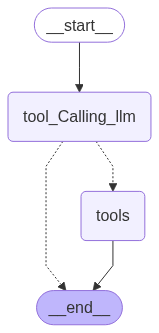

In [19]:
#stategraph 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node definition
def tool_Calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

##graph builder
builder= StateGraph(State)
builder.add_node("tool_Calling_llm",tool_Calling_llm)
builder.add_node("tools", ToolNode(tools))

##adding edges to the graph
builder.add_edge(START, "tool_Calling_llm")
builder.add_conditional_edges("tool_Calling_llm",
                              #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
                              #if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
                       tools_condition)
builder.add_edge("tools", END)
##compiling the graph
graph = builder.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
response=graph.invoke({"messages": ["What is AI?"]})

In [21]:
response['messages'][-1].content

'{"query": "what is AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Artificial intelligence - Wikipedia", "url": "https://en.wikipedia.org/wiki/Artificial_intelligence", "content": "Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to", "score": 0.90289277, "raw_content": null}, {"title": "What Is Artificial Intelligence? Definition, Uses, and Types", "url": "https://www.coursera.org/articles/what-is-artificial-intelligence", "content": "Data Ethics, Artificial Intelligence and Machine Learning (AI/ML), Business Ethics, Artificial Neural Networks, Data Science, Team Building, Strategic Thinking, Market Opportuni

In [22]:
for m in response['messages']:
    m.pretty_print() 

================================ Human Message =================================

What is AI?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (1763hdy33)
 Call ID: 1763hdy33
  Args:
    exclude_domains: []
    include_domains: []
    include_images: False
    query: what is AI
    search_depth: basic
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "what is AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Artificial intelligence - Wikipedia", "url": "https://en.wikipedia.org/wiki/Artificial_intelligence", "content": "Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops a

In [23]:
response=graph.invoke({"messages": ["What is 2 multiplied by 7?"]})
for m in response['messages']:
    m.pretty_print() 

================================ Human Message =================================

What is 2 multiplied by 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (j80n0egfk)
 Call ID: j80n0egfk
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: multiply

14


In [24]:
response=graph.invoke({"messages": ["What is 2 multiplied by 7? and what is the capital of France?"]})
for m in response['messages']:
    m.pretty_print() 

================================ Human Message =================================

What is 2 multiplied by 7? and what is the capital of France?
================================== Ai Message ==================================
Tool Calls:
  multiply (vrqt036dy)
 Call ID: vrqt036dy
  Args:
    a: 2
    b: 7
  tavily_search (86fg9c82w)
 Call ID: 86fg9c82w
  Args:
    query: What is the capital of France
================================= Tool Message =================================
Name: multiply

14
================================= Tool Message =================================
Name: tavily_search

{"query": "What is the capital of France", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is the Capital of France? - WorldAtlas", "url": "https://www.worldatlas.com/articles/what-is-the-capital-of-france.html", "content": "Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. L

### ReAgent architecture :


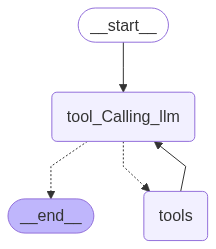

In [25]:
#stategraph 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node definition
def tool_Calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

##graph builder
builder= StateGraph(State)
builder.add_node("tool_Calling_llm",tool_Calling_llm)
builder.add_node("tools", ToolNode(tools))

##adding edges to the graph
builder.add_edge(START, "tool_Calling_llm")
builder.add_conditional_edges("tool_Calling_llm",
                              #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
                              #if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
                       tools_condition)
builder.add_edge("tools", "tool_Calling_llm")
##compiling the graph
graph = builder.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response=graph.invoke({"messages": ["what is the capital of France? and what is 2 multiplied by 7?"]})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the capital of France? and what is 2 multiplied by 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (6ybx5z2k6)
 Call ID: 6ybx5z2k6
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0sy0hs7j4)
 Call ID: 0sy0hs7j4
  Args:
    query: What is the capital of France
================================= Tool Message =================================
Name: tavily_search

{"query": "What is the capital of France", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is the Capital of France? - WorldAtlas", "url": "https://www.worldatlas.com/articles/what-is-the-capital-of-france.html", "content": "Paris is the capital city of France. C

##### adding memory in langgraph 


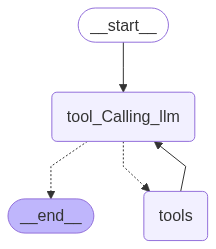

In [27]:
#stategraph 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

##node definition
def tool_Calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

##graph builder
builder= StateGraph(State)
builder.add_node("tool_Calling_llm",tool_Calling_llm)
builder.add_node("tools", ToolNode(tools))

##adding edges to the graph
builder.add_edge(START, "tool_Calling_llm")
builder.add_conditional_edges("tool_Calling_llm",
                              #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
                              #if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
                       tools_condition)
builder.add_edge("tools", "tool_Calling_llm")
##compiling the graph
graph = builder.compile(checkpointer=memory)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
config={"configurable":{"thread_id":"1"}}
response = graph.invoke({"messages":"hi, my name is lux"}, config=config)
response
print(response["messages"][-1].content)


Nice to meet you, Lux!


In [29]:
response = graph.invoke({"messages":"hey what is my name?"}, config=config)
response
print(response["messages"][-1].content)

Your name is Lux!


### STREAMING:


In [30]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [31]:
def superbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

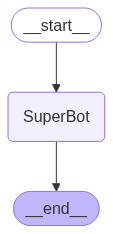

In [36]:
graph=StateGraph(State)
##adding the node to the graph
graph.add_node("SuperBot",superbot)
##adding edges to the graph
graph.add_edge(START, "SuperBot")
graph.add_edge("SuperBot", END)

graph_builder=graph.compile(checkpointer=memory)


from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [38]:
config={"configurable":{"thread_id":"1"}}
graph_builder.invoke({"messages":"hi, my name is lux and i love to design"}, config=config)



{'messages': [HumanMessage(content='hi, my name is lux and i love to design', additional_kwargs={}, response_metadata={}, id='31150bae-9d56-42b4-9195-12bc33c4b852'),
  AIMessage(content='Nice to meet you, Lux! It sounds like you have a passion for design. What kind of design do you enjoy doing the most? Are you into graphic design, interior design, fashion design, or something else?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 2222, 'total_tokens': 2267, 'completion_time': 0.163263365, 'prompt_time': 0.08999136, 'queue_time': 0.05595004699999999, 'total_time': 0.253254725}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--72d1e5e7-1daf-43cd-85f0-8a9028017afd-0', usage_metadata={'input_tokens': 2222, 'output_tokens': 45, 'total_tokens': 2267})]}

In [ ]:
##streaming response in stream mode as updates
config={"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":"hi, my name is lux and i love to design"}, config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='<tool-use>{"tool_calls": []}</tool-use>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 2282, 'total_tokens': 2295, 'completion_time': 0.132887402, 'prompt_time': 0.088319916, 'queue_time': 0.054910422000000014, 'total_time': 0.221207318}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--7c5bc760-1c0f-45ce-818e-87173eedbca0-0', usage_metadata={'input_tokens': 2282, 'output_tokens': 13, 'total_tokens': 2295})]}}


In [41]:
## streaming response in stream mode as values
config={"configurable":{"thread_id":"4"}}
for chunk in graph_builder.stream({"messages":"hi, my name is lux and i love to design"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='hi, my name is lux and i love to design', additional_kwargs={}, response_metadata={}, id='c8949a84-2b13-4c16-8661-699f968f0105')]}
{'messages': [HumanMessage(content='hi, my name is lux and i love to design', additional_kwargs={}, response_metadata={}, id='c8949a84-2b13-4c16-8661-699f968f0105'), AIMessage(content='<tool-use>{"tool_calls": []}</tool-use>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 2222, 'total_tokens': 2235, 'completion_time': 0.139768133, 'prompt_time': 0.086639958, 'queue_time': 0.055524140999999985, 'total_time': 0.226408091}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--63a7f5ac-8c55-4fba-8c7b-6d56cd356782-0', usage_metadata={'input_tokens': 2222, 'output_tokens': 13, 'total_tokens': 2235})]}


In [43]:
config={"configurable":{"thread_id":"5"}}
for chunk in graph_builder.stream({"messages":"hi, my name is lux and i love to design, particularly styling and fashion"}, config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Lux, that's great! Fashion design and styling can be so much fun. What kind of fashion design are you most interested in? Are you into haute couture, streetwear, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 2301, 'total_tokens': 2344, 'completion_time': 0.246400312, 'prompt_time': 0.089021412, 'queue_time': 0.056006644999999994, 'total_time': 0.335421724}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--50d24b0d-6742-4073-8fd4-5068d3bbd372-0', usage_metadata={'input_tokens': 2301, 'output_tokens': 43, 'total_tokens': 2344})]}}


In [45]:
config={"configurable":{"thread_id":"5"}}
async for event in graph_builder.astream_events({"messages":"hi, my name is lux and i love to design, particularly styling and fashion"}, config, version="v2"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Lux, that's great! Fashion design and styling can be so much fun. What kind of fashion design are you most interested in? Are you into haute couture, streetwear, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 2301, 'total_tokens': 2344, 'completion_time': 0.246400312, 'prompt_time': 0.089021412, 'queue_time': 0.056006644999999994, 'total_time': 0.335421724}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--50d24b0d-6742-4073-8fd4-5068d3bbd372-0', usage_metadata={'input_tokens': 2301, 'output_tokens': 43, 'total_tokens': 2344})]}}
{'SuperBot': {'messages': [AIMessage(content="Hi Lux, that's great! Fashion design and styling can be so much fun. What kind of fashion design are you most interested in? Are you into haute couture, streetwear, or something else?", additional_kwargs={}, response_met

# human feedback in the loop 


In [61]:
import os 
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
llm = ChatGroq(model="llama3-70b-8192")
llm = init_chat_model("groq:llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10ef43be0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10f90cd30>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [68]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [69]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

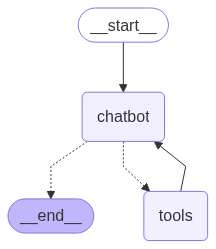

In [70]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [71]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (ht61ysgfs)
 Call ID: ht61ysgfs
  Args:
    query: I need some expert guidance and assistance for building an AI agent.


In [72]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (ht61ysgfs)
 Call ID: ht61ysgfs
  Args:
    query: I need some expert guidance and assistance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

No tool call is needed in this case. I will respond directly.

That sounds like great advice! LangGraph does seem like a reliable and extensible option for building an AI agent. Would you like to know more about how to get started with LangGraph or are there any specific aspects of building an AI agent you'd like some guidance on?
